# Analise de dados ENEM 2017

O Exame Nacional do Ensino Médio (Enem) é a maior prova do Brasil, aplicada anualmente para mais de 5 milhões de estudantes do ensino médio. A prova do Enem é realizada em dois domingos consecutivos e se divide em quatro áreas: Linguagens e Códigos; Ciências Humanas; Ciências da Natureza; Matemática e Redação.

Neste notebook serão apresentados e explorados os dados do ENEM 2017 contidos em um conjunto de dados que pode ser encontrado no site do [Inep](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem).

O significado de cada feature também pode ser visto no Dicionário de Dados no site do Inep

Esta análise tem como objetivo responder as seguintes perguntas:
- Média de notas por cidade, estado e/ou região
- Histograma por cidade, estado e/ou região e com detalhamento por área/disciplina
- Mapa geográfico com pontuações (pontos)
- Classificação das 10 melhores e das 10 piores pontuações por cidade, estado e/ou região
- Curva linear de pontuações por população (em milhares)
- mapa de calor de correlação entre a média das pontuações e o índice IDH
- Cidades com maior população tendem a ter piores pontuações na média? 


# 0.0 Imports

In [57]:
import inflection
import zipfile
import pandas         as pd
import numpy          as np
import seaborn        as sns
import plotly.express as px
from matplotlib                 import gridspec
from matplotlib                 import pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [58]:
# Função para formatar notação científica
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Tamanho dos Graficos
sns.set(style = "darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})
#pd.options.display.float_format = "{:,.2f}".format

##  Carregando os dados

 Este dataset possui 167 colunas, essas colunas em sua maioria são valores que não interessam para essa análise, então serão selecionadas apenas as colunas relevantes para o objetivo dessa análise. Este é um Dataset muito volumoso, por isso trabalaharei apenas com uma amostra.

In [59]:
#MIcrodados Enem
colunas = ['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ESCOLA',  
  'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO','Q006']

with zipfile.ZipFile('data/microdados_enem_2017.zip') as z:
    with z.open('DADOS/MICRODADOS_ENEM_2017.csv') as f:
        # Criar uma lista com estas colunas que serão usadas
        df = pd.read_csv(f,sep=';', encoding='ISO-8859-1', usecols=colunas, nrows=50000)
        
# carregar o Dataset cidades
#colunas = ['Município','IDHMunicipal_2010', 'População_estimada_pessoas_2019']

#df_cidades = pd.read_csv('data/cidades.csv', usecols=colunas)


In [60]:
colunas = ['Município','IDHMunicipal_2010', 'População_estimada_pessoas_2019']

df_cidades = pd.read_csv('data/cidades.csv', usecols=colunas)


In [61]:
df_cidades.head()

Município  População_estimada_pessoas_2019 IDHMunicipal_2010
0        Adamantina                            35068              0,79
1            Adolfo                             3562              0,73
2             Aguaí                            36305             0,715
3    Águas da Prata                             8180             0,781
4  Águas de Lindóia                            18705             0,745

In [62]:
cols = ['Município','IDHMunicipal_2010', 'lat', 'long']
df_coord= pd.read_csv('data/cidade_geolocalizacao.csv', usecols=cols)

In [63]:
df_coord['populacao'] = df_cidades['População_estimada_pessoas_2019']
df_coord.head()


Município IDHMunicipal_2010      lat     long  populacao
0        Adamantina              0,79 -21.6867 -51.0763      35068
1            Adolfo              0,73 -21.2357 -49.6442       3562
2             Aguaí             0,715 -22.0592 -46.9794      36305
3    Águas da Prata             0,781 -21.9464 -46.7192       8180
4  Águas de Lindóia             0,745 -22.4719 -46.6291      18705

In [64]:
df_cidades = df_coord.copy()

In [65]:
df_cidades.columns =[['NO_MUNICIPIO_PROVA', 'idh', 'lat', 'long', 'populacao']]

In [66]:
#Renomear colunas para concatenar os datasets
df_cidades.columns=['NO_MUNICIPIO_PROVA', 'idh', 'lat', 'long', 'populacao',]

df = pd.merge(df, df_cidades, how='left', on='NO_MUNICIPIO_PROVA')

In [67]:
# Obter os endereços em coordenadas LATITUDE e LONGITUDE 

#locator = Nominatim(user_agent="mygeocoder")
#
#geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
#
#df_cidade['geolocalizacao'] = df_cidade['Município'].apply(geocode)
#
#df_cidades['geolocalizacao'][0]
#
## Filtrando lat e long da coluna
#df_cidade['lat']= df_cidade['geolocalizacao'].apply(lambda loc: loc.latitude if loc else None)
#df_cidade['long']= df_cidade['geolocalizacao'].apply(lambda loc: loc.longitude if loc else None)

# 1.  Descrição dos Dados

Esta etapa tem por objetivo criar uma consciência situacional inicial e permitir um entendimento de como os dados estão estruturados.

##  Renomear Colunas

In [68]:
#Renomear as colunas do dataset microdados
cols_old = ['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ESCOLA', 
       'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH','NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q006', 'idh', 'lat',
       'long', 'populacao']


#Função para renomear colunas

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df.columns = cols_new

In [69]:
df.columns = ['inscricao', 'ano', 'faixa_etaria', 'sexo',
       'estado_civil', 'cor_raca', 'tp_escola', 
       'municipio', 'estado', 'ciencias_natureza', 'ciencias_humanas',
       'linguagens_codigos', 'matematica', 'redacao', 'renda_familiar', 'idh', 'lat',
       'long', 'populacao']

##  Verificando o Tamanho do Dataset

In [70]:
print(f'Numbers of rows: { df.shape[0] }\n')
print(f'Numbers of columns: { df.shape[1] }')

Numbers of rows: 55434

Numbers of columns: 19


No ano de 2017 o enem teve 6.731278 inscritos, mas por questão de infra usarei apenas uma amostra

In [71]:
#df_cidades
print(f'Numbers of rows: { df_cidades.shape[0] }\n')
print(f'Numbers of columns: { df_cidades.shape[1] }')

Numbers of rows: 5570

Numbers of columns: 5


##  Verificando os tipos de dados

In [72]:
df.dtypes

inscricao               int64
ano                     int64
faixa_etaria            int64
sexo                   object
estado_civil            int64
cor_raca                int64
tp_escola               int64
municipio              object
estado                 object
ciencias_natureza     float64
ciencias_humanas      float64
linguagens_codigos    float64
matematica            float64
redacao               float64
renda_familiar         object
idh                    object
lat                   float64
long                  float64
populacao               int64
dtype: object

In [73]:
df_cidades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NO_MUNICIPIO_PROVA  5570 non-null   object 
 1   idh                 5570 non-null   object 
 2   lat                 5570 non-null   float64
 3   long                5570 non-null   float64
 4   populacao           5570 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 217.7+ KB


##  Tratamento dos dados

- Para este estudo será usado apenas os dados dos participantes que possuam as 5 notas válidas, ou seja, aqueles que participaram de todas as provas, mais a redação.

In [74]:
df.isna().sum()

inscricao                 0
ano                       0
faixa_etaria              0
sexo                      0
estado_civil              0
cor_raca                  0
tp_escola                 0
municipio                 0
estado                    0
ciencias_natureza     15234
ciencias_humanas      13327
linguagens_codigos    13327
matematica            15234
redacao               13327
renda_familiar            0
idh                       0
lat                       0
long                      0
populacao                 0
dtype: int64

In [75]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(df.isnull().sum() / df.shape[0]*100).sort_values(ascending = False)

ciencias_natureza    27.4813
matematica           27.4813
ciencias_humanas     24.0412
redacao              24.0412
linguagens_codigos   24.0412
long                  0.0000
lat                   0.0000
idh                   0.0000
renda_familiar        0.0000
inscricao             0.0000
ano                   0.0000
estado                0.0000
municipio             0.0000
tp_escola             0.0000
cor_raca              0.0000
estado_civil          0.0000
sexo                  0.0000
faixa_etaria          0.0000
populacao             0.0000
dtype: float64

 - De acordo este estudo preliminar no ano de 2017 teve mais de 27% de faltas

In [76]:
# Elimina as linhas com nota NaN, que provavelmente corresponde a alunos ausentes a alguma das provas.
df = df.dropna()

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40160 entries, 0 to 55431
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inscricao           40160 non-null  int64  
 1   ano                 40160 non-null  int64  
 2   faixa_etaria        40160 non-null  int64  
 3   sexo                40160 non-null  object 
 4   estado_civil        40160 non-null  int64  
 5   cor_raca            40160 non-null  int64  
 6   tp_escola           40160 non-null  int64  
 7   municipio           40160 non-null  object 
 8   estado              40160 non-null  object 
 9   ciencias_natureza   40160 non-null  float64
 10  ciencias_humanas    40160 non-null  float64
 11  linguagens_codigos  40160 non-null  float64
 12  matematica          40160 non-null  float64
 13  redacao             40160 non-null  float64
 14  renda_familiar      40160 non-null  object 
 15  idh                 40160 non-null  object 
 16  lat 

# EDA

Este passo tem como objetivo fazer uma análise mais detalhada dos dados e conhecer um pouco mais do perfil dos inscritos

## Criando a variável de nota média e Mediana

In [78]:
# Cria nota média
df['nota_media'] = (df['ciencias_natureza']+
                    df['ciencias_humanas'] +
                    df['linguagens_codigos']+ 
                    df['matematica'] +
                    df['redacao']) / 5

#eliminando os estudantes que ficaram com nota 0 por qualquer outro motivo (e.g. eliminados)
df = df[df['nota_media'] != 0]

In [79]:
# Cria nota mediana
df['nota_mediana'] = (df['ciencias_natureza']+
                    df['ciencias_humanas'] +
                    df['linguagens_codigos']+ 
                    df['matematica'] +
                    df['redacao'])
df['nota_mediana'] = pd.DataFrame( df['nota_mediana'].apply( np.median) )
#eliminando os estudantes que ficaram com nota 0 por qualquer outro motivo (e.g. eliminados)
df = df[df['nota_mediana'] != 0]

In [80]:
#Mudar dtypes
df['idh']= df['idh'].str.replace(',','.').astype(float)

### Criando a coluna Região

In [81]:

regiao = {
    "Norte":['AM', 'PA', 'RR', 'AC','RO','AP', 'TO'],
    "Sul":['PR', 'SC', 'RS'],
    "Centro_Oeste":['MT', 'MS', 'GO', 'DF'],
    "Nordeste":['BA', 'CE','MA', 'PB', 'PE', 'RN', 'SE', 'AL', 'PI'],
    "Sudeste":['SP', 'RJ', 'MG','ES']}

for r in regiao:
    df.loc[ df['estado'].isin(regiao[r]), 'regiao'] = r

## Participantes por sexo

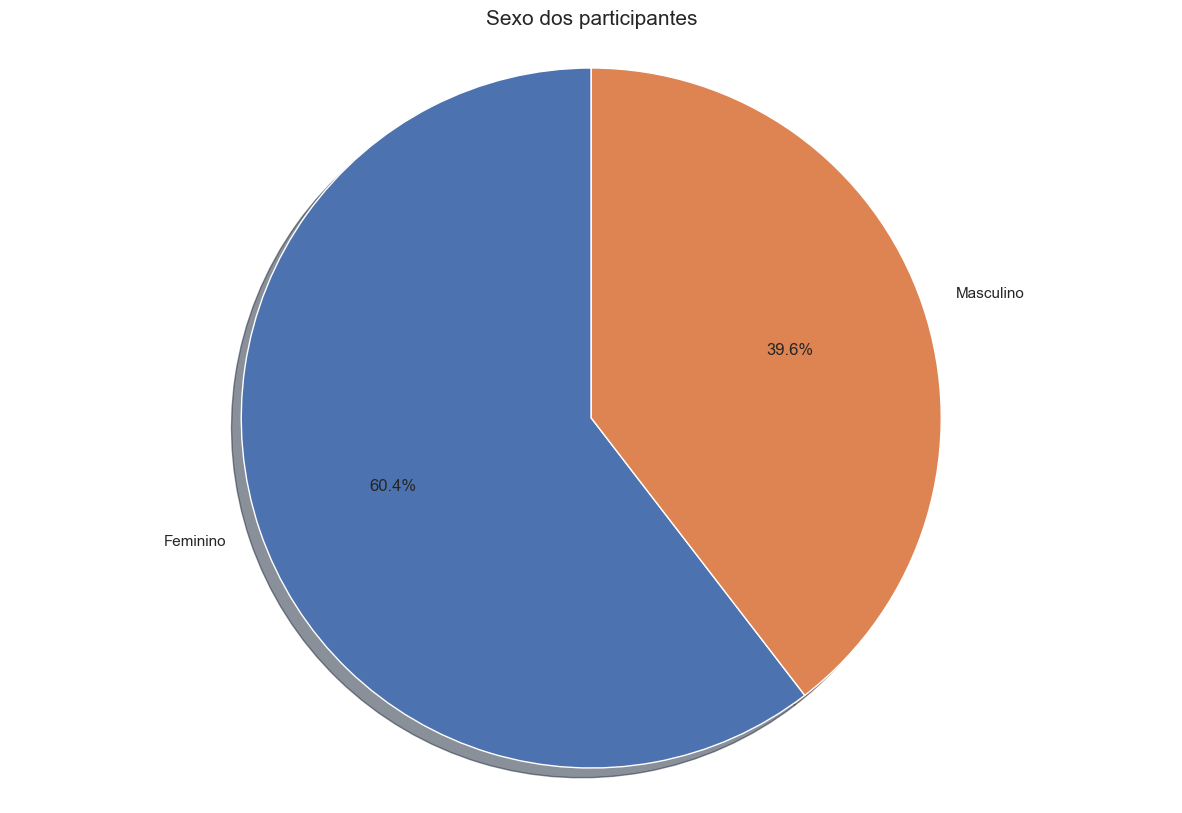

In [82]:
#
labels = ['Feminino' , 'Masculino']
sizes = [df['sexo'].value_counts()[0], df['sexo'].value_counts()[1]]
fig1, ax1 = plt.subplots()
plt.title(f'Sexo dos participantes', fontsize=15)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


A porcentagem de participantes do sexo feminino é superior à do sexo masculino, isso era de se esperar porque na população do Brasil existem mais mulheres do que homens (62,2%), entretanto apenas essa diferença na proporção na população do Brasil não é o bastante para explicar essa discrepância tão alta.

## Renda Familiar

In [83]:
df.loc[df["renda_familiar"].isin(["Q"]), "CLASSE_ECONOMICA"] = "A"
df.loc[df["renda_familiar"].isin(["N", "O", "P"]), "CLASSE_ECONOMICA"] = "B"
df.loc[df["renda_familiar"].isin(["H", "I", "J", "K", "L", "M"]), "CLASSE_ECONOMICA"] = "C"
df.loc[df["renda_familiar"].isin(["E", "F", "G"]), "CLASSE_ECONOMICA"] = "D"
df.loc[df["renda_familiar"].isin(["B", "C", "D"]), "CLASSE_ECONOMICA"] = "E"
df.loc[df["renda_familiar"].isin(["A"]), "CLASSE_ECONOMICA"] = "Sem renda"

In [84]:
pd.DataFrame(df["CLASSE_ECONOMICA"].value_counts())

CLASSE_ECONOMICA
E                     23673
D                      8780
C                      5166
Sem renda              1113
B                      1016
A                       412

C:\Users\PC\AppData\Local\Temp\ipykernel_10476\1128148428.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



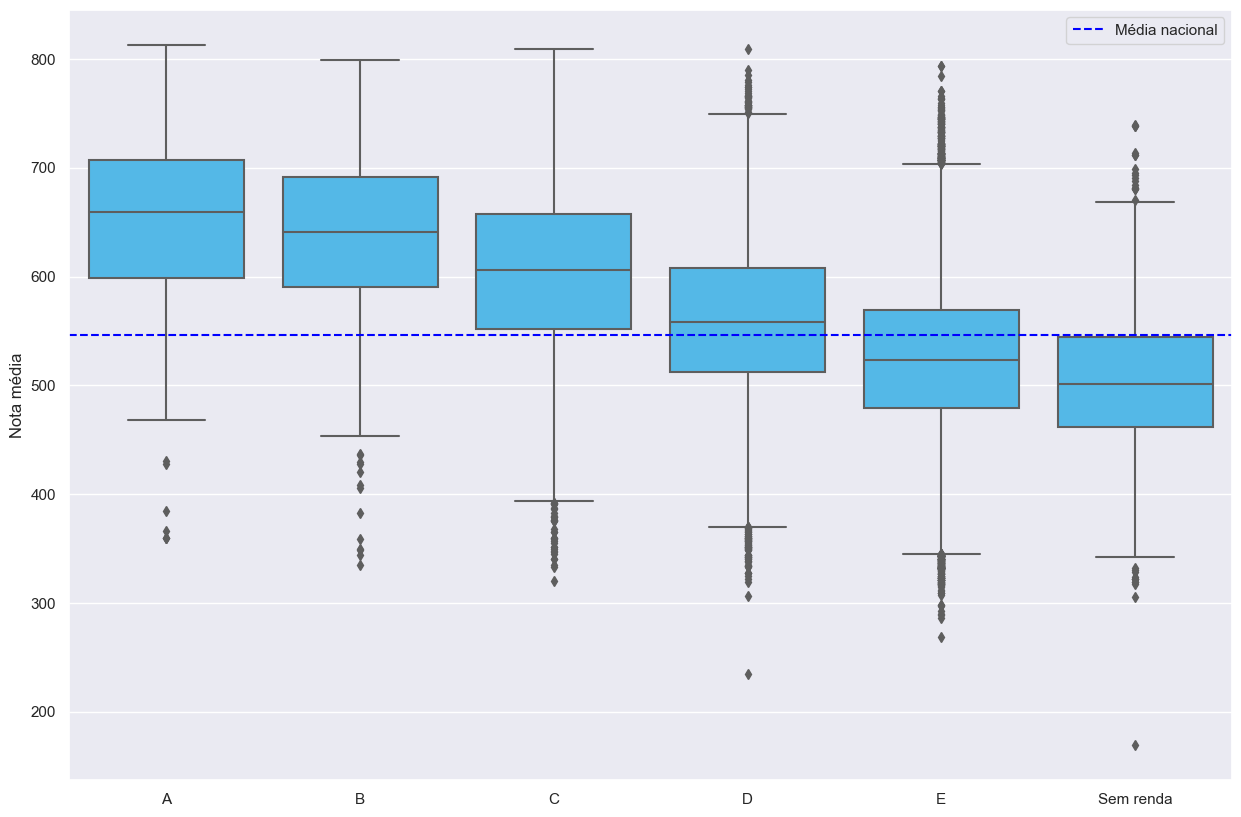

In [85]:
ax = sns.boxplot(x = "CLASSE_ECONOMICA", y = "nota_media", data = df, 
                 order = df.groupby("CLASSE_ECONOMICA").median()["nota_media"].\
                 sort_values(ascending = False).keys(), 
                 color = "#3bc1ff")

ax.axhline(df["nota_media"].mean(), ls='--', color="blue", label = "Média nacional")

ax.set_ylabel("Nota média")
ax.set_xlabel("")

plt.legend()

Nesse gráfico é possível observar que quanto maior a renda, maiores as chances de atingir um melhor desempenho.
A situação se agrava quando isolamos os dois extremos das classes, já que participantes sem renda e da classe E que atingem notas acima ou até mesmo próximas de 700 são considerado outliers, enquanto nas classes mais altas é algo que está dentro da normalidade.

## Participante por Raça/ Cor

In [86]:
var = 'cor_raca'
A = 'Não declarado'
B = 'Branca'
C = 'Preta'
D = 'Parda'
E = 'Amarela'
F = 'Indígena'
plotdata = pd.concat([df['nota_media'], df[var].map({0: A, 1: B, 2: C, 3: D, 4: E, 5: F})], axis=1)
pd.DataFrame(plotdata['cor_raca']).value_counts()

cor_raca     
Parda            18006
Branca           15222
Preta             5095
Amarela            887
Não declarado      769
Indígena           181
dtype: int64

A maioria dos inscritos se declaram pardos.

[Text(0.5, 1.0, 'Cor/Raça')]

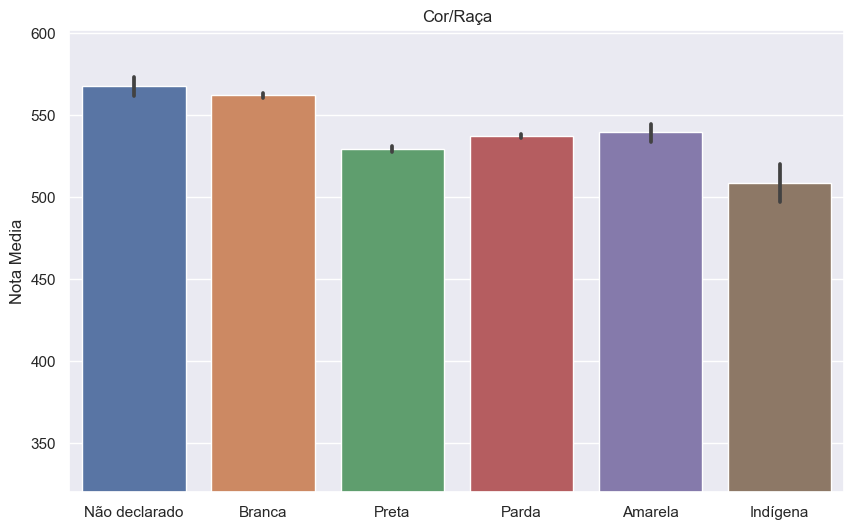

In [87]:
var = 'cor_raca'
A = 'Não declarado'
B = 'Branca'
C = 'Preta'
D = 'Parda'
E = 'Amarela'
F = 'Indígena'
plotdata = pd.concat([df['nota_media'], df[var].map({0: A, 1: B, 2: C, 3: D, 4: E, 5: F})], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.barplot(x=var, y=df['nota_media'], data=plotdata, order=[A, B, C, D, E, F])
fig.axis(ymin=320);
ax.set(ylabel="Nota Media")
ax.set(xlabel="")
ax.set(title="Cor/Raça")

Apesar de a Maioria dos inscritos se declarar pardo, nesse gráfico é possível observar que pessoas que se declaram brancas tem maiores notas

## Tipo de escola

[Text(0.5, 1.0, 'Tipo de escola do Ensino Médio')]

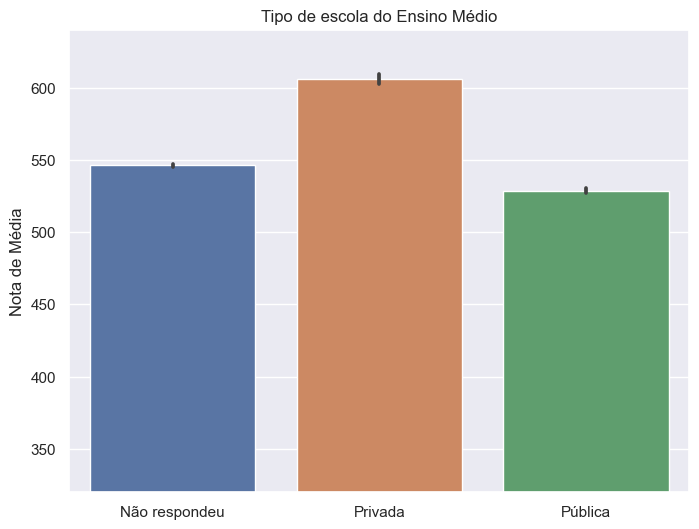

In [88]:
var = 'tp_escola'
A = 'Não respondeu'
B = 'Pública'
C = 'Privada'
plotdata = pd.concat([df['nota_media'], df[var].map({1: A, 2: B, 3:C})], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.barplot(x=var, y=df['nota_media'], data=plotdata )
fig.axis(ymin=320);
ax.set(ylabel="Nota de Média")
ax.set(xlabel="")
ax.set(title="Tipo de escola do Ensino Médio")

Alunos de escolas privadas tem notas mais altas. O que mais uma vez confirma que a condição social pode influenciar no aprendizado do aluno

## Distribuição das notas

In [89]:
# Distribuição das notas
provas = ['ciencias_natureza',
       'ciencias_humanas', 'linguagens_codigos', 'matematica', 'redacao']

df[provas].describe()

ciencias_natureza  ciencias_humanas  linguagens_codigos  matematica  \
count         40160.0000        40160.0000          40160.0000  40160.0000   
mean            528.6216          548.2153            532.8648    539.7229   
std              74.7140           81.5067             61.6712    108.8161   
min               0.0000            0.0000              0.0000      0.0000   
25%             471.3000          491.6000            495.4000    455.2000   
50%             527.6000          557.5000            537.7000    526.7000   
75%             582.7000          607.1000            575.7000    610.3000   
max             805.7000          845.9000            779.3000    993.9000   

         redacao  
count 40160.0000  
mean    580.9905  
std     175.6845  
min       0.0000  
25%     500.0000  
50%     580.0000  
75%     680.0000  
max    1000.0000

Tirando a distribuição da nota de Redação, todas as outras notas possuem distribuições próximas a normalidade.
Das provas normais, matemática é a que possui a maior nota máxima, porém isso não implica que é a prova que os participantes tem melhor desempenho, já que, também dentro das provas normais, é a que possui maior desvio padrão, mostrando que é uma nota que varia muito.

Text(0.5, 0, '')

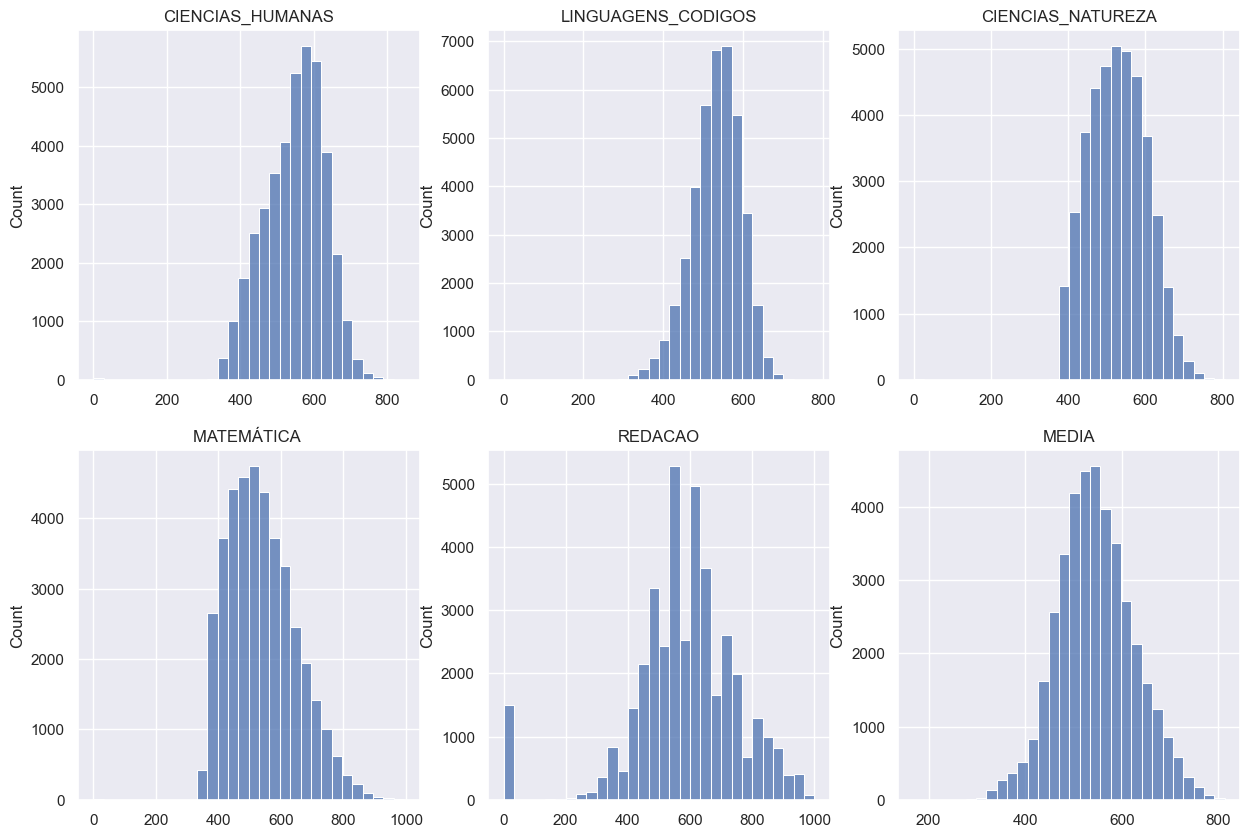

In [90]:
plt.subplot(2, 3, 1)
ax = sns.histplot(df["ciencias_humanas"], bins = 30)
ax.set_title("CIENCIAS_HUMANAS")
ax.set_xlabel("")

plt.subplot(2, 3, 2)
ax = sns.histplot(df["linguagens_codigos"], bins = 30)
ax.set_title("LINGUAGENS_CODIGOS")
ax.set_xlabel("")

plt.subplot(2, 3, 3)
ax = sns.histplot(df["ciencias_natureza"], bins = 30)
ax.set_title("CIENCIAS_NATUREZA")
ax.set_xlabel("")

plt.subplot(2, 3, 4)
ax = sns.histplot(df["matematica"], bins = 30)
ax.set_title("MATEMÁTICA ")
ax.set_xlabel("")

plt.subplot(2, 3, 5)
ax = sns.histplot(df["redacao"], bins = 30)
ax.set_title("REDACAO")
ax.set_xlabel("")

plt.subplot(2, 3, 6)
ax = sns.histplot(df["nota_media"], bins = 30)
ax.set_title("MEDIA")
ax.set_xlabel("")

#plt.savefig("output_images/histplot_materias.png", bbox_inches = "tight")


## Participantes por estado

In [91]:
df_estado = df[['estado', 'nota_media']].groupby('estado').sum().reset_index()
df_estado

estado   nota_media
0      AC  132446.2800
1      AL  327588.3600
2      AM  298783.6200
3      AP  120614.5400
4      BA 1522314.3200
5      CE 1335589.1000
6      DF  509661.0600
7      ES  501536.1000
8      GO  641113.4600
9      MA  679628.0600
10     MG 2410281.4400
11     MS  321951.7000
12     MT  352011.8800
13     PA 1383096.8600
14     PB  615796.8000
15     PE 1312740.9800
16     PI  364985.1000
17     PR  784285.7000
18     RJ 1768295.0800
19     RN  611846.1000
20     RO  198097.0000
21     RR  103261.0200
22     RS 1083897.7800
23     SC  388930.1800
24     SE  341475.2200
25     SP 3620268.3000
26     TO  200198.2800

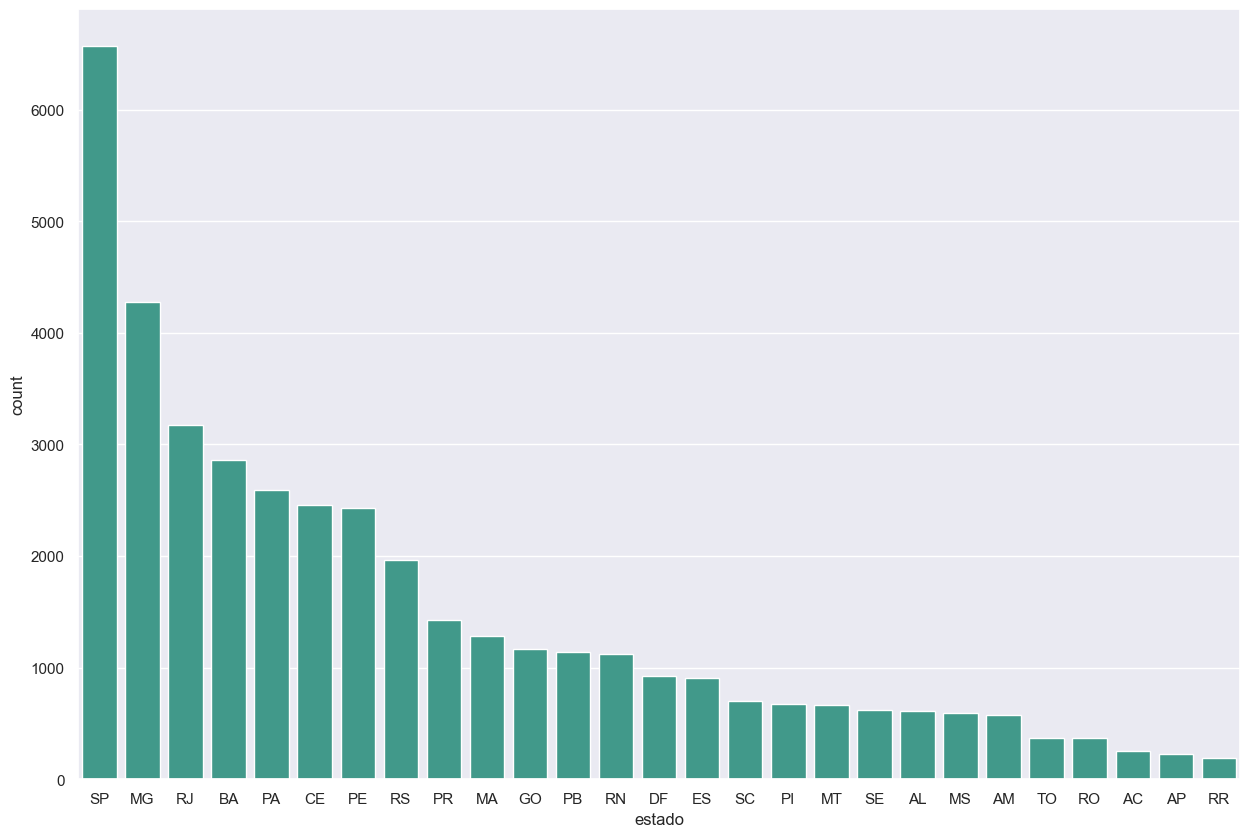

In [92]:
# Plotando o gráfico com o plotly
ax = sns.countplot(x = "estado", data = df, 
                 order = df["estado"].value_counts(ascending = False).keys(), 
                 color = "#32a893")

## Relação entre as notas

Para verificar se o desempenho do participante em uma determinada matéria afeta diretamente seu desempenho em outra matéria, vamos utilizar o coeficiente de correlação de pearson, que mede a correlação linear entre duas variáveis.

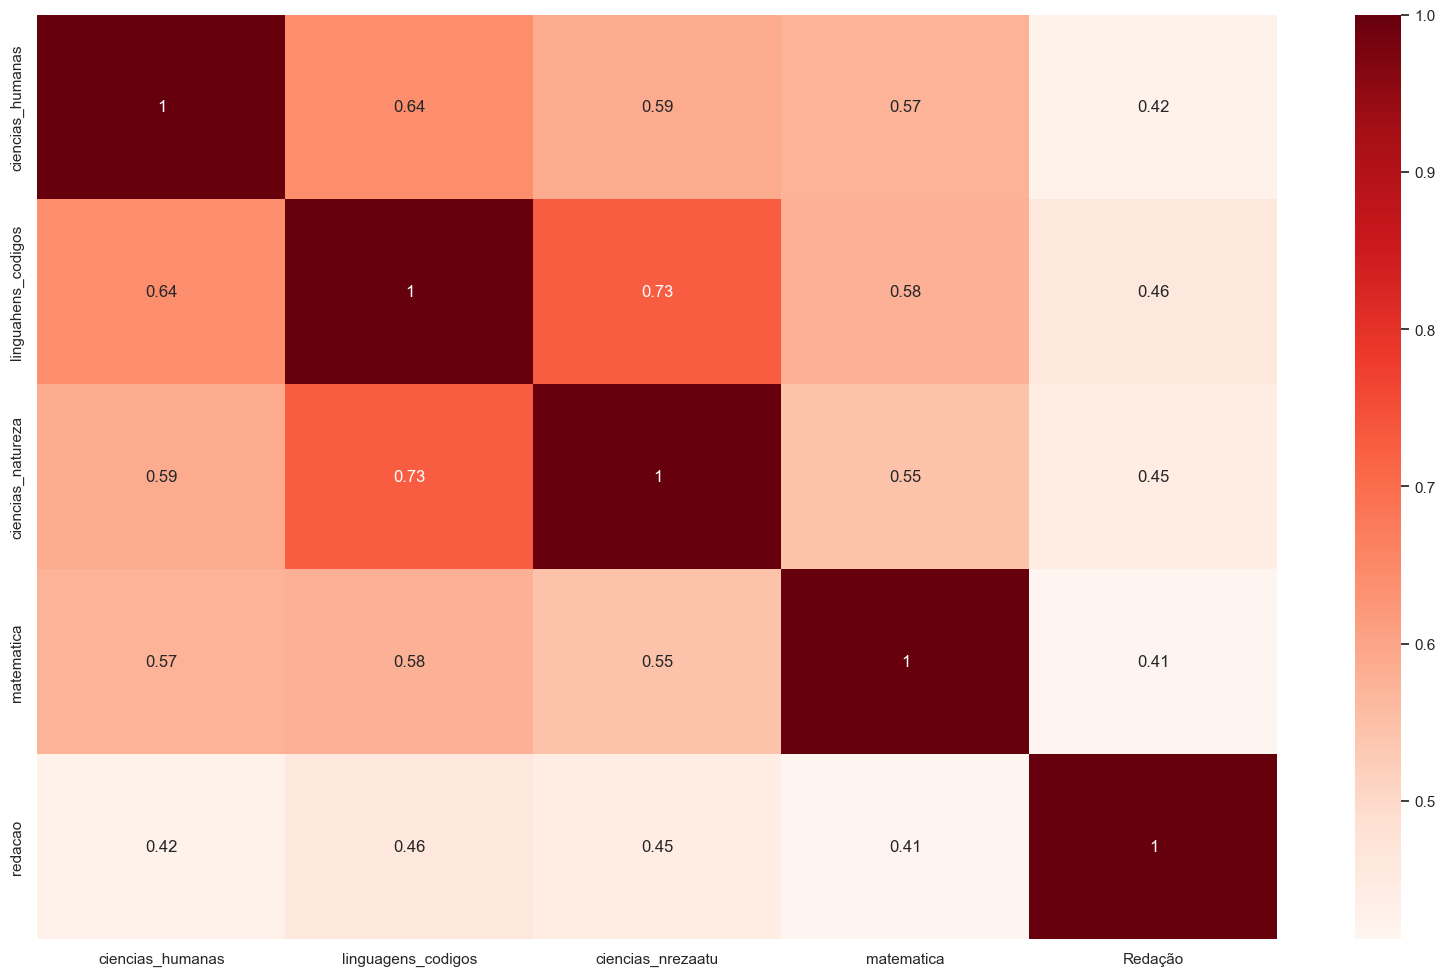

In [93]:
hm  = df[['ciencias_natureza','ciencias_humanas', 'linguagens_codigos', 'matematica', 'redacao']].corr("pearson")

plt.figure(figsize=(20,12))
ax = sns.heatmap(hm, annot = True, cmap = "Reds", vmax = 1)
ax.set_xticklabels(['ciencias_humanas', 'linguagens_codigos', 
                    "ciencias_nrezaatu", "matematica", "Redação"])
ax.set_yticklabels(["ciencias_humanas", "linguahens_codigos", 
                    "ciencias_natureza", "matematica", "redacao"]);


Com mapa de calor, é possível notar que todas as correlações são consideradas altas (maior que 0.5), exceto redação. Isso mostra que caso um participante tire uma nota muito alta em uma matéria, será muito difícil ele tirar uma nota baixa em outra, seja ela qual for.

# Respondendo as perguntas

## Média de notas por matéria em cada estado

In [94]:
ax = df.filter(items=['estado','ciencias_natureza','ciencias_humanas', 'linguagens_codigos', 
                      'matematica', 'redacao']).groupby('estado').mean()
ax

ciencias_natureza  ciencias_humanas  linguagens_codigos  matematica  \
estado                                                                        
AC               520.2161          530.1594            522.2759    514.2217   
AL               515.7532          536.5288            520.7488    527.0049   
AM               509.0823          523.1024            515.5235    508.0450   
AP               513.8179          526.2354            509.7908    515.7135   
BA               516.8144          534.3754            519.3974    515.0563   
CE               520.0600          539.4684            523.4273    539.9677   
DF               534.7669          556.4019            542.7144    541.6853   
ES               536.2399          556.1245            537.4030    553.2233   
GO               532.0096          549.4827            535.4333    540.1088   
MA               516.8005          530.9537            515.4905    517.4899   
MG               544.0271          564.0127            544.1106    560.7855   
MS               535.1892          541.7163            531.2047    538.2172   
MT               523.3101          540.0811            521.3605    530.1944   
PA               520.0847          539.3146            519.1501    514.8934   
PB               520.0189          539.9484            524.3926    533.5522   
PE               521.9537          537.5810            526.2575    534.8097   
PI               523.7217          537.1787            517.7001    530.9933   
PR               533.5891          555.4145            540.2388    549.8539   
RJ               534.5339          558.1817            541.6968    553.7550   
RN               529.4346          544.1332            528.5955    540.7899   
RO               522.1630          535.9520            520.8708    521.2421   
RR               545.6401          564.8706            543.1513    535.1353   
RS               533.2861          554.2054            543.0297    548.5576   
SC               537.7926          557.6814            541.2420    549.5689   
SE               525.0144          545.1952            524.4622    535.4822   
SP               532.3608          557.2876            544.5217    548.6359   
TO               522.5260          531.0067            523.8635    527.8354   

        redacao  
estado           
AC     572.6908  
AL     580.7201  
AM     542.3652  
AP     567.9476  
BA     573.8854  
CE     593.8975  
DF     582.3377  
ES     594.0642  
GO     580.4270  
MA     574.0625  
MG     604.7884  
MS     563.7037  
MT     547.7761  
PA     571.4836  
PB     587.6977  
PE     576.0723  
PI     590.0000  
PR     565.0805  
RJ     598.3044  
RN     586.0660  
RO     555.2279  
RR     572.1925  
RS     577.5280  
SC     572.0851  
SE     606.0256  
SP     571.5064  
TO     578.3914

**1. Qual é a Média de notas por cidade, estado e/ou região**

In [95]:
media_estado = df.loc[:, ['estado', 'nota_media']].groupby('estado')

media_estado = media_estado.sum().sort_values('nota_media', ascending=False).reset_index()

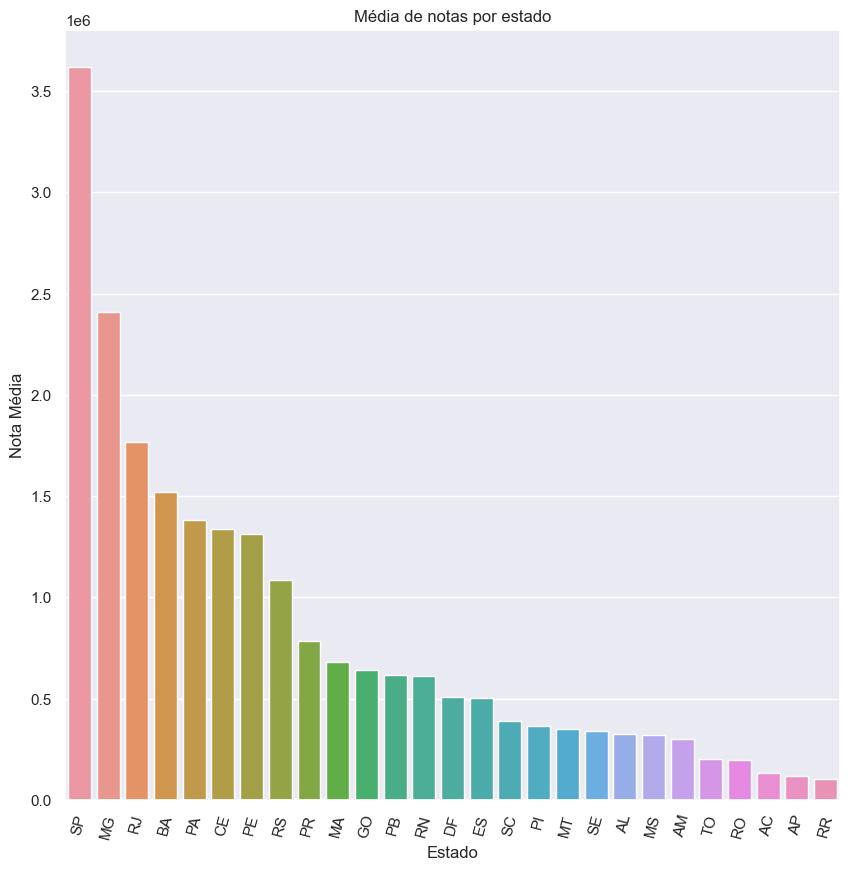

In [96]:
plt.figure(figsize=(10,10))
ax = sns.barplot(
    data=media_estado,
    x='estado',
    y='nota_media'
)

ax.set(
    title='Média de notas por estado',
    xlabel='Estado',
    ylabel='Nota Média'
)

plt.xticks(rotation=75);

O estado de São Paulo tem a maior méida, já era de se esperar, pois é também o estado mais populoso.

In [97]:
media_regiao = df[['ciencias_natureza','ciencias_humanas', 'linguagens_codigos',
                   'matematica', 'redacao', 'regiao']].groupby('regiao').mean().reset_index()
media_regiao


regiao  ciencias_natureza  ciencias_humanas  linguagens_codigos  \
0  Centro_Oeste           531.6174          548.1590            533.9150   
1      Nordeste           520.4043          537.6459            522.4598   
2         Norte           519.8088          536.2212            519.9005   
3       Sudeste           536.4007          559.3345            543.3726   
4           Sul           534.1666          555.2245            541.7496   

   matematica  redacao  
0    538.2520 571.5463  
1    529.6839 582.9158  
2    516.4353 566.9854  
3    553.4834 588.1059  
4    549.1833 572.2537

C:\Users\PC\AppData\Local\Temp\ipykernel_10476\287363913.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



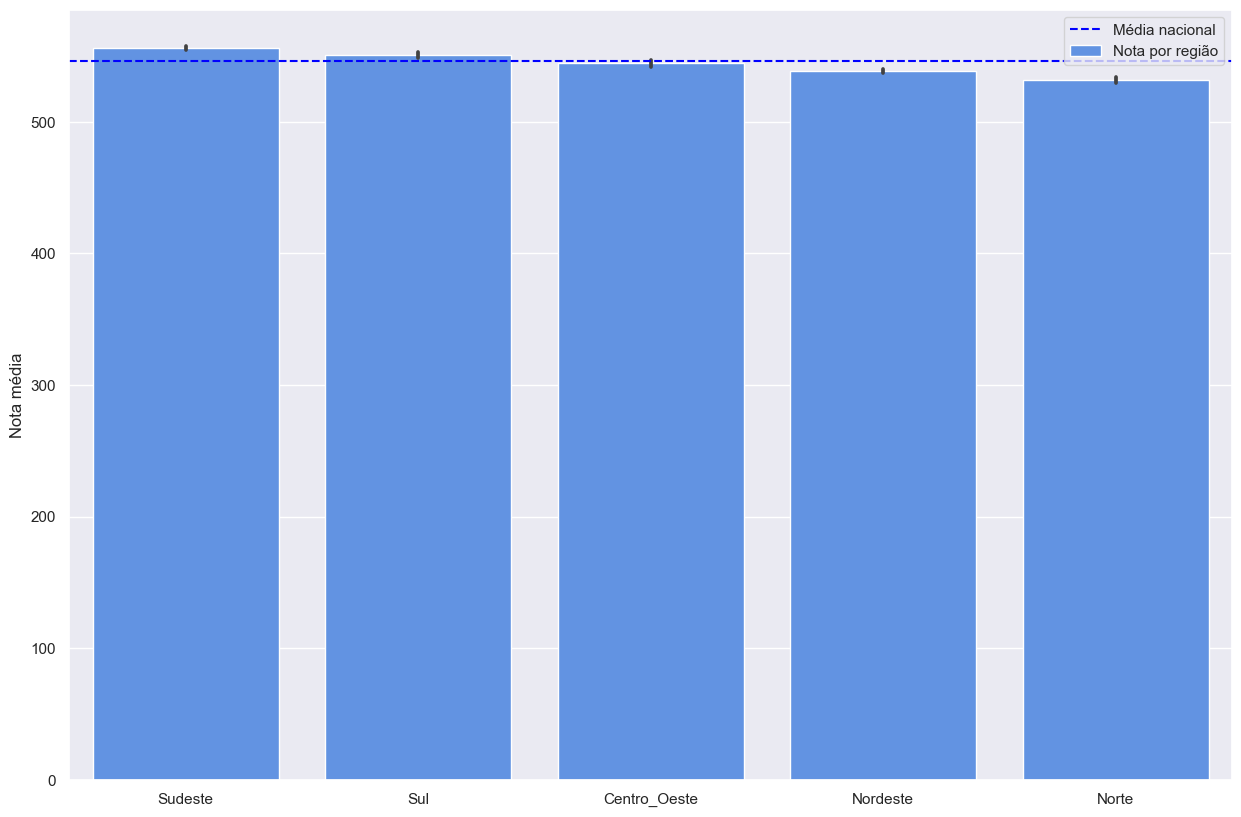

In [98]:
ax = sns.barplot(x = "regiao", y = "nota_media", data = df, 
                 order = df.groupby('regiao').mean()["nota_media"].
                        sort_values(ascending = False).keys(), 
                 color = "#4D8EF7", label = "Nota por região")

ax.axhline(df["nota_media"].mean(), ls='--', color="blue", label = "Média nacional")

ax.set_ylabel("Nota média")
ax.set_xlabel("")

plt.legend(title = "")

- Neste Gráfico é possível observar que o as regiões Norte e Nordeste tem a nota média abaixo da média nacional. O Sudeste tem a maior média, porém isso não reflete que tenha tido melhores notas, pois no Sudeste estão os participantes com as maiores notas.

C:\Users\PC\AppData\Local\Temp\ipykernel_10476\3520740923.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



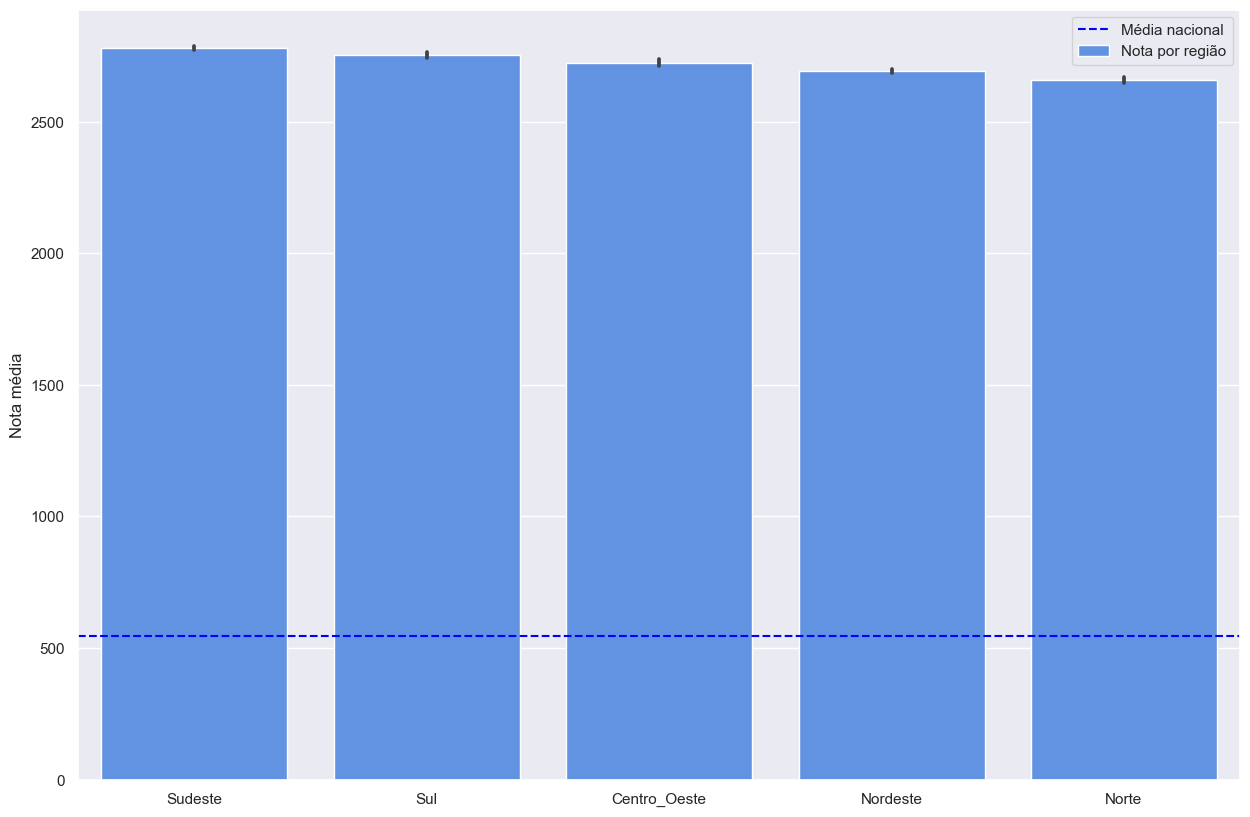

In [99]:
ax = sns.barplot(x = "regiao", y = "nota_mediana", data = df, 
                 order = df.groupby('regiao').median()["nota_mediana"].
                        sort_values(ascending = False).keys(), 
                 color = "#4D8EF7", label = "Nota por região")

ax.axhline(df["nota_media"].mean(), ls='--', color="blue", label = "Média nacional")

ax.set_ylabel("Nota média")
ax.set_xlabel("")

plt.legend(title = "")

In [100]:
mediana_estado = df.loc[:, ['estado', 'nota_mediana']].groupby('estado')

mediana_estado = mediana_estado.sum().sort_values('nota_mediana', ascending=False).reset_index()


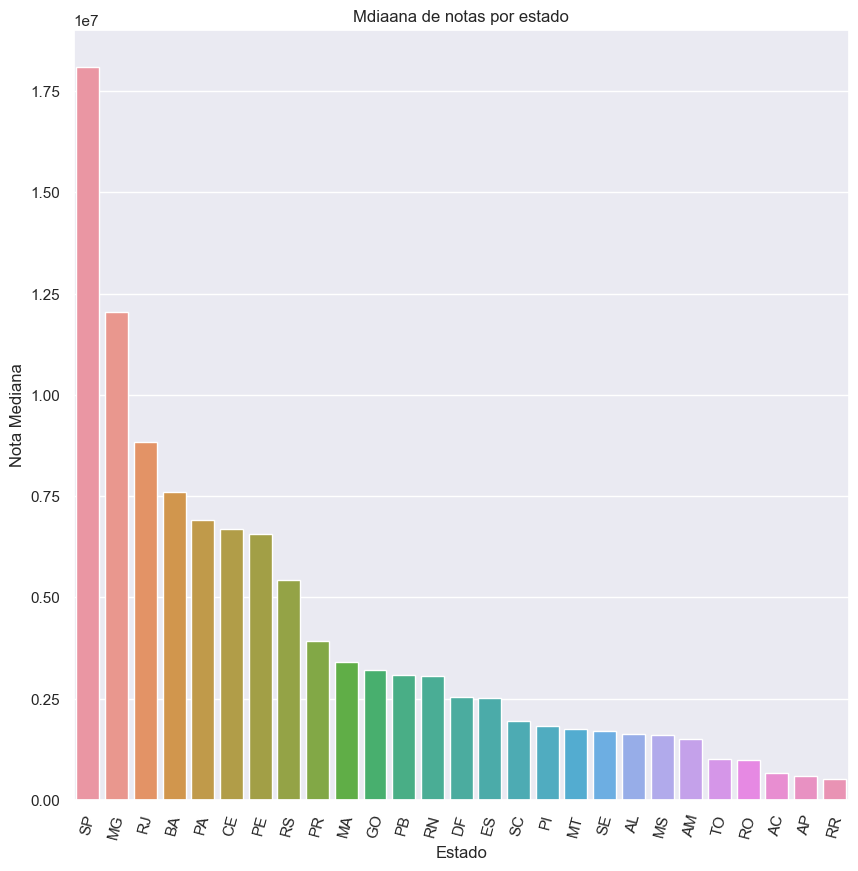

In [101]:
plt.figure(figsize=(10,10))
ax = sns.barplot(
    data=mediana_estado,
    x='estado',
    y='nota_mediana'
)

ax.set(
    title='Mdiaana de notas por estado',
    xlabel='Estado',
    ylabel='Nota Mediana'
)

plt.xticks(rotation=75);

Ao observar os Gráfico com a mediana, é possível observar que o fato da Região sudeste ter um estdo mais popuploso, enviesa o estudo.

**2. Construa Histograma por cidade, estado e/ou região e com detalhamento por área/disciplina**

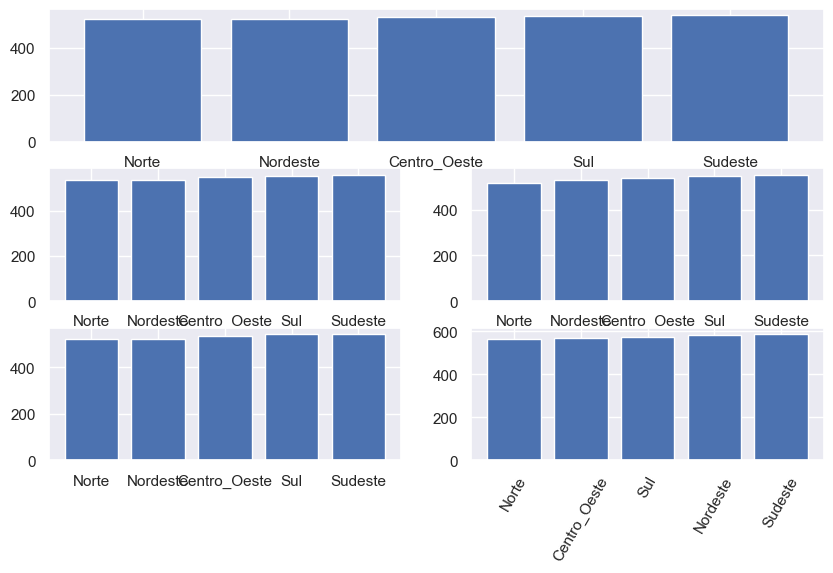

In [102]:
fig = plt.figure(figsize=(10,10) )
specs = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)
              
                 
ax1 = fig.add_subplot( specs[0, : ]) #first  row
ax2 = fig.add_subplot( specs[1, 0]) 
ax3 = fig.add_subplot( specs[1, 1]) 
ax4 = fig.add_subplot( specs[2, 0]) 
ax5 = fig.add_subplot( specs[2, 1]) 

                 
# Gráfico de notas ciencias da natureza por Região
aux = media_regiao[['ciencias_natureza', 'regiao']].groupby('regiao').sum().sort_values('ciencias_natureza',ascending=True ).reset_index()


ax1.bar(aux['regiao'], aux['ciencias_natureza'])
plt.xticks(rotation=60);

# Grafico de notas Ciencias Humanas por Região
aux1 = media_regiao[['ciencias_humanas', 'regiao']].groupby('regiao').sum().sort_values('ciencias_humanas',ascending=True ).reset_index()


ax2.bar(aux1['regiao'], aux1['ciencias_humanas'])
plt.xticks(rotation=60);


# Grafico de notas Matemática por Região
aux2 = media_regiao[['matematica', 'regiao']].groupby('regiao').sum().sort_values('matematica',ascending=True ).reset_index()


ax3.bar(aux2['regiao'], aux2['matematica'])
plt.xticks(rotation=60);

# Grafico de notas Linguagens de código por Região
aux3 = media_regiao[['linguagens_codigos', 'regiao']].groupby('regiao').sum().sort_values('linguagens_codigos',ascending=True ).reset_index()


ax4.bar(aux3['regiao'], aux3['linguagens_codigos'])
plt.xticks(rotation=60);

# Grafico de notas Redação por Região
aux4 = media_regiao[['redacao', 'regiao']].groupby('regiao').sum().sort_values('redacao',ascending=True ).reset_index()

ax5.bar(aux4['regiao'], aux4['redacao'])
plt.xticks(rotation=60);


In [103]:
cols_notas = ['ciencias_natureza','ciencias_humanas', 'linguagens_codigos', 'matematica', 'redacao']
df_notas = df[cols_notas].copy()

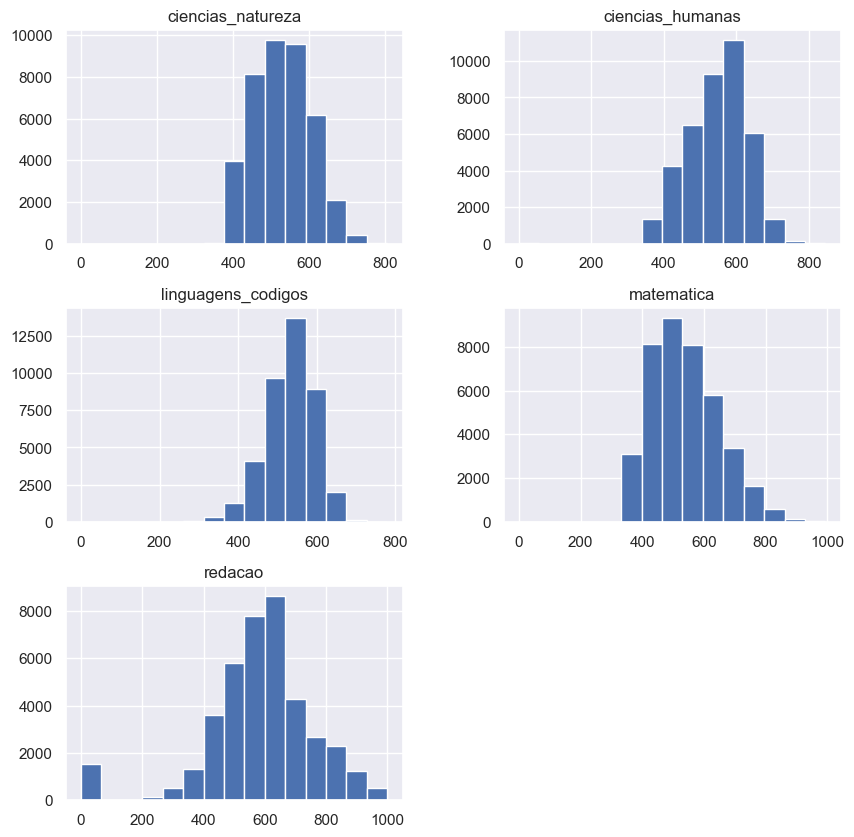

In [104]:
df_notas.hist(bins=15, figsize=(10,10));

**3. Mapa geográfico com pontuações (pontos)**

In [105]:
df_aux = df[['nota_media', 'lat', 'long']].copy()
fig = px.scatter_mapbox(df_aux,
                        lat='lat',
                        lon='long',
                        size='nota_media',
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=5,
                        zoom=7)
fig.update_layout(mapbox_style = 'open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 't':0, 'b':0})
fig.show()


**4. Classificação das 10 melhores e das 10 piores pontuações por cidade.**

In [106]:
report_melhores = df[['municipio','nota_media' ]].sort_values('nota_media',ascending=False)
report_melhores.head(10)

municipio  nota_media
35759                    Natal    813.0200
23821                 Brasília    811.6200
53230                   Recife    809.2400
25300  Venda Nova do Imigrante    808.7800
7133                  Brasília    808.1200
20246      São José dos Campos    807.9800
1831                  São Luís    806.5800
29124                 Teresina    805.6600
42402                São Paulo    805.2200
23289        Bragança Paulista    802.5600

In [107]:
report_piores = df[['municipio','nota_media' ]].sort_values('nota_media',ascending=False)
report_piores.tail(10)

municipio  nota_media
3805                Recife    298.4000
43370       Santa Quitéria    298.2800
34624               Marabá    296.9400
33596             Teresina    292.5800
22025  Palmeira dos Índios    290.1200
37196             Altamira    288.7800
53325             Brasília    285.8200
3297        João Monlevade    268.8400
1518               Caruaru    234.7200
30227                  Jaú    169.6000

**5. mapa de calor de correlação entre a média das pontuações e o índice IDH**

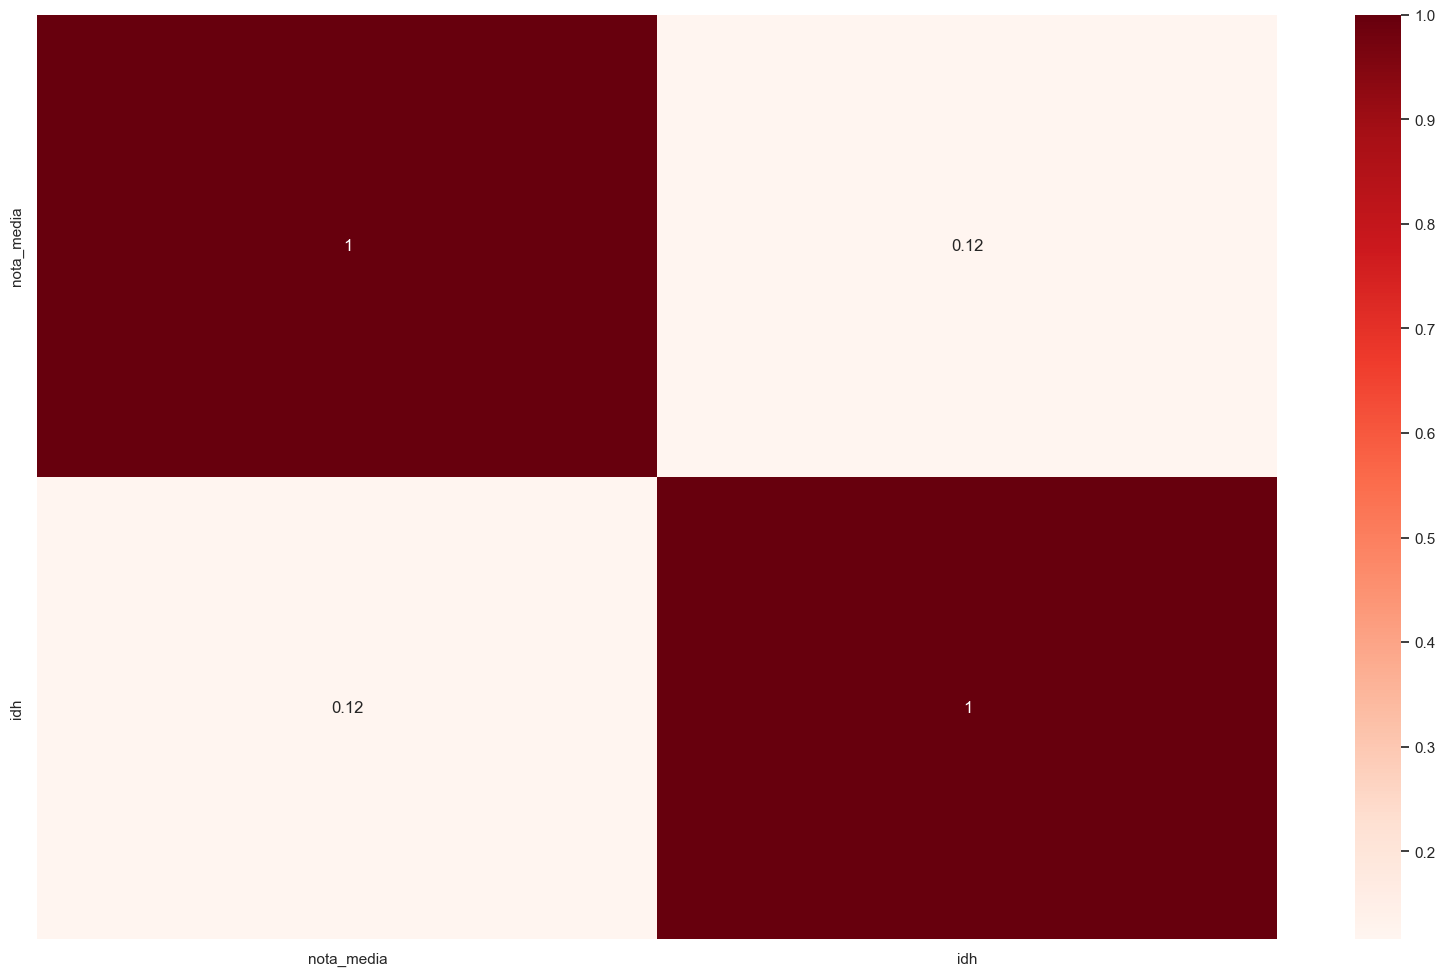

In [108]:
hm  = df[['nota_media','idh']].corr("pearson")

plt.figure(figsize=(20,12))
ax = sns.heatmap(hm, annot = True, cmap = "Reds", vmax = 1)
ax.set_xticklabels(['nota_media','idh'])
ax.set_yticklabels(['nota_media','idh']);


Analisando a matriz de correlação de dados, é possível perceber que a nota média tem fraca correlação (abaixo de 0.5) com o IDH do município.

**6.Cidades com maior população tendem a ter piores pontuações na média?**

In [109]:
df.head()

inscricao   ano  faixa_etaria sexo  estado_civil  cor_raca  tp_escola  \
0  170003336736  2017            11    F             1         1          1   
3  170001663645  2017            12    F             1         1          1   
4  170001663646  2017            13    M             1         3          1   
5  170001663647  2017             5    F             1         1          1   
6  170001663647  2017             5    F             1         1          1   

      municipio estado  ciencias_natureza  ...  redacao  renda_familiar  \
0    Araraquara     SP           445.4000  ... 560.0000               D   
3         Lages     SC           604.0000  ... 580.0000               D   
4        Maceió     AL           482.1000  ... 580.0000               C   
5  Cachoeirinha     RS           558.8000  ... 540.0000               J   
6  Cachoeirinha     RS           558.8000  ... 540.0000               J   

     idh      lat     long  populacao  nota_media  nota_mediana    regiao  \
0 0.8150 -21.7887 -48.1773     236072    536.2800     2681.4000   Sudeste   
3 0.7700 -27.8166 -50.3259     157544    589.9000     2949.5000       Sul   
4 0.7210  -9.6477 -35.7339    1018948    557.3400     2786.7000  Nordeste   
5 0.6270 -29.9493 -51.0899       2275    559.0000     2795.0000       Sul   
6 0.7570 -29.9493 -51.0899     130293    559.0000     2795.0000       Sul   

   CLASSE_ECONOMICA  
0                 E  
3                 E  
4                 E  
5                 C  
6                 C  

[5 rows x 23 columns]

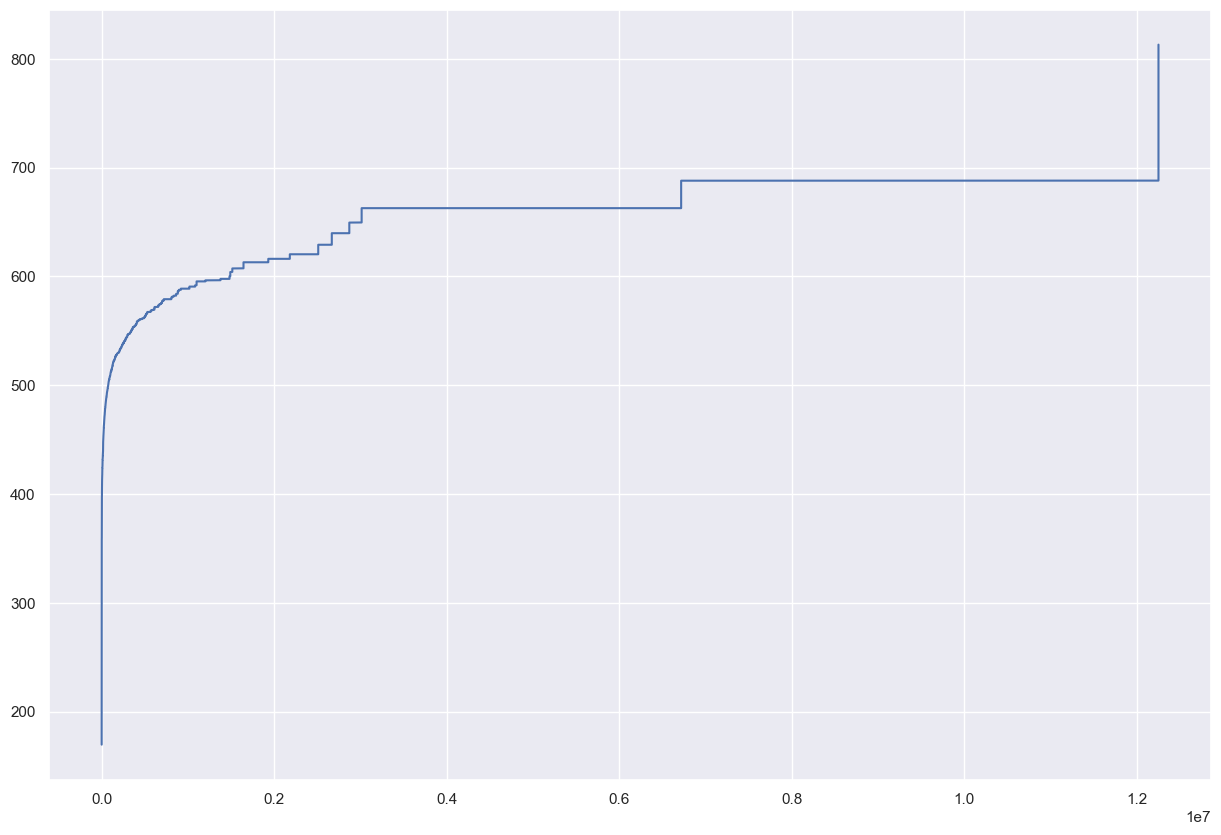

In [110]:
x=df['populacao'].sort_values(ascending=True)
y=df['nota_media'].sort_values(ascending=True)
plt.plot(x, y)

Neste gráfico é possivel observar que cidades com populacao maior tendem a ter notas mais altas

In [112]:
df.sample(10000).to_csv('data/dataset_enem.csv', index=False)